In [1]:
%matplotlib notebook
import numpy as np
import sigpy as sp
import sigpy.mri as mr
import sigpy.plot as pl
import matplotlib.pyplot as plt
import cupy as cp

from zte_recon.data_zte import Data_Arc_ZTE, Data_CalcPhyllo_ZTE, Data_Product_ZTE, Data_EndpointsFile_ZTE 
from zte_recon.arc_zte_traj import read_params_from_kacq
from zte_recon.util.sens import est_maps_3d
from zte_recon.bart_dims import ksp_to_bart, coord_to_bart
from zte_recon.plot import plot_coherence_pathways, plot_spokes_temporal_color, plot_3d_axes, plot_ksp_spoke

from arc_zte_sim.metrics import refocusing_metrics, cov_uniformity_metric, percentage_TRs_with_refocusing_metric
from arc_zte_sim.rotate_spokes import save_Rs_txt

/home/shreya/cont-slew-zte/venv/lib/python3.10/site-packages/sigpy/config.py:27: UserWarning: Importing cupy.cuda.cudnn failed. For more details, see the error stack below:
libcudnn.so.8: cannot open shared object file: No such file or directory
  warnings.warn(


In [2]:
seg_rot_file = '/home/shreya/cont-slew-zte/rot_txt_files/seg_golden3d_rotMats_large.txt'

# Shared acquisition parameters
dt_sampling = 8
grad_dt_sampling = 4
nPtsPerSpoke = None
rBW=31.25e3

# Reconstruction parameters
FOV_scale = 1
FOV_scale_dir = [1,1,1]
ndrop_ROpts = 1
img_shape = [256,256,256]

In [3]:
###############

### Phyllotaxis
matlab_save_dir = '/mikBIG/shreya/cont_slew_zte_eval/20250415/Series4/'
smoothness = 10
gm_flag = True
segsPerInterleaf = 1

Data_phyllozte = Data_CalcPhyllo_ZTE(smoothness, gm_flag, segsPerInterleaf, 
                 matlab_save_dir, nPtsPerSpoke, rBW, FOV_scale, FOV_scale_dir, ndrop_ROpts)


###############

### AZTEK
matlab_save_dir = '/mikBIG/shreya/cont_slew_zte_eval/20250415/Series6/'
endpoints_txt_path = '/mikBIG/shreya/cont_slew_zte_data/20250415/Series6/kacq_aztek.220756946'  #[1,2,5] for 1506 txt file

Data_aztek = Data_EndpointsFile_ZTE(endpoints_txt_path, 
                 matlab_save_dir, nPtsPerSpoke, rBW,
                 FOV_scale, FOV_scale_dir, ndrop_ROpts)

###############

### Standard
matlab_save_dir = '/mikBIG/shreya/cont_slew_zte_eval/20250418/Series6/'
endpoints_txt_path = '/mikBIG/shreya/cont_slew_zte_data/20250418/Series6/kacq_stdzte.93347660'  #[1,2,5] for 1506 txt file

Data_standard = Data_EndpointsFile_ZTE(endpoints_txt_path,
                matlab_save_dir, nPtsPerSpoke, rBW, 
                 FOV_scale, FOV_scale_dir, ndrop_ROpts)


###############

### ArcZTE
spoke_rot_file = None # not needed if kacq file is provided
seg_rot_file = '/home/shreya/cont-slew-zte/rot_txt_files/seg_golden3d_rotMats_large.txt'
grad_segment_file = '/mikBIG/shreya/cont_slew_zte_data/20250415/Series11/kacq_arc_zte.90839'
matlab_save_dir = '/mikBIG/shreya/cont_slew_zte_eval/20250415/Series11/'

params = read_params_from_kacq(grad_segment_file)
arc_angle = params['arc_angle']
a_grad = params['a_grad']
points_per_spoke = params['points_per_spoke']
points_before_curve = params['points_before_curve']

Data_arczte = Data_Arc_ZTE(spoke_rot_file, seg_rot_file, arc_angle, points_per_spoke, 
                 points_before_curve, dt_sampling, grad_dt_sampling, a_grad, grad_segment_file,
                 matlab_save_dir, FOV_scale=FOV_scale, FOV_scale_dir=FOV_scale_dir, ndrop_ROpts=ndrop_ROpts)


Loading ksp from h5 dir: /mikBIG/shreya/cont_slew_zte_eval/20250415/Series4/
Setting nPtsPerSpoke to opxres 256
Loading ksp from h5 dir: /mikBIG/shreya/cont_slew_zte_eval/20250415/Series6/
Setting nPtsPerSpoke to opxres 256
Loading ksp from h5 dir: /mikBIG/shreya/cont_slew_zte_eval/20250418/Series6/
Setting nPtsPerSpoke to opxres 256
Loading ksp from h5 dir: /mikBIG/shreya/cont_slew_zte_eval/20250415/Series11/
Setting nPtsPerSpoke to opxres 256


<IPython.core.display.Javascript object>


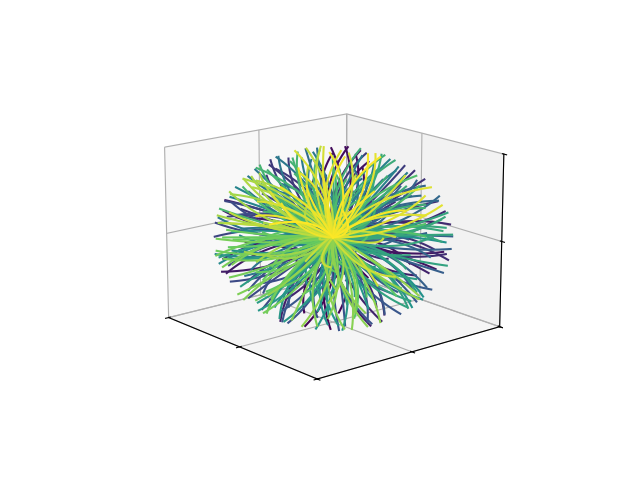

In [4]:
plot_3d_axes()
ax = plt.gca()
seg_num = 0
spokes_per_seg = 384
plot_spokes_temporal_color(ax, Data_arczte.coord_radial_spokes[seg_num*384:(seg_num+1)*384, :])
ax.elev = 16
ax.azim = 140

# To plot without grid lines
# ax.set_axis_off()
# fig = plt.gcf()
# ax.elev = 58
# ax.azim = 144

In [51]:
plt.savefig('saved_figures/fig_arcFrame0.png', dpi=500)

<IPython.core.display.Javascript object>


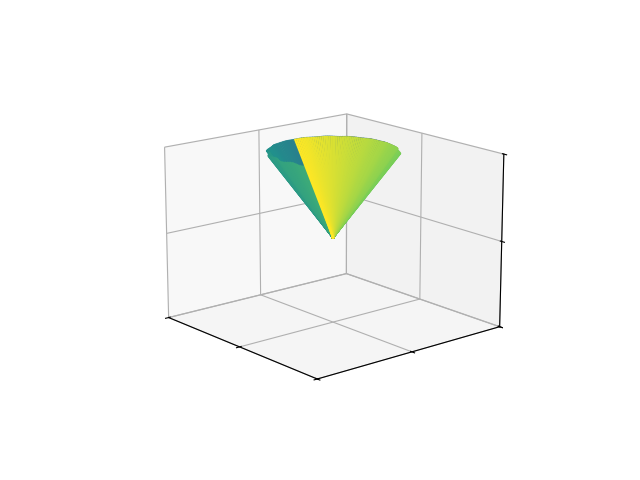

In [5]:
plot_3d_axes()
ax = plt.gca()
plot_spokes_temporal_color(ax, Data_standard.coord_radial_spokes[384*10:384*11])
ax.elev = 16
ax.azim = 140

In [52]:
plt.savefig('saved_figures/fig1c_standard.png', dpi=500)

<IPython.core.display.Javascript object>


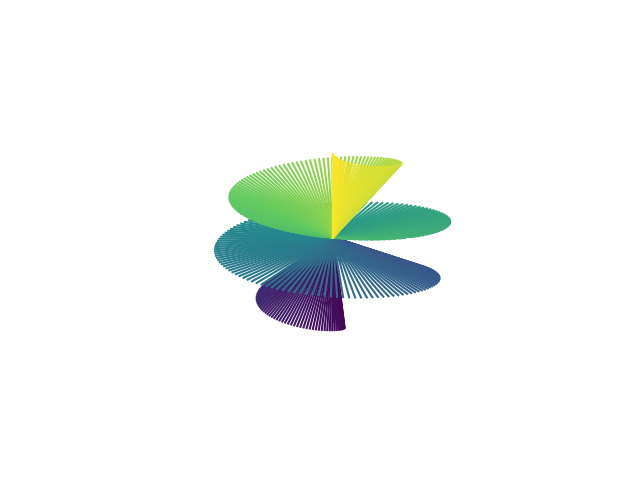

In [6]:
plot_3d_axes()
ax = plt.gca()
plot_spokes_temporal_color(ax, Data_phyllozte.coord_radial_spokes[0:384])
ax.elev = 16
ax.azim = 140

In [34]:
plt.savefig('saved_figures/fig1c_phyllo.png', dpi=500)

<IPython.core.display.Javascript object>


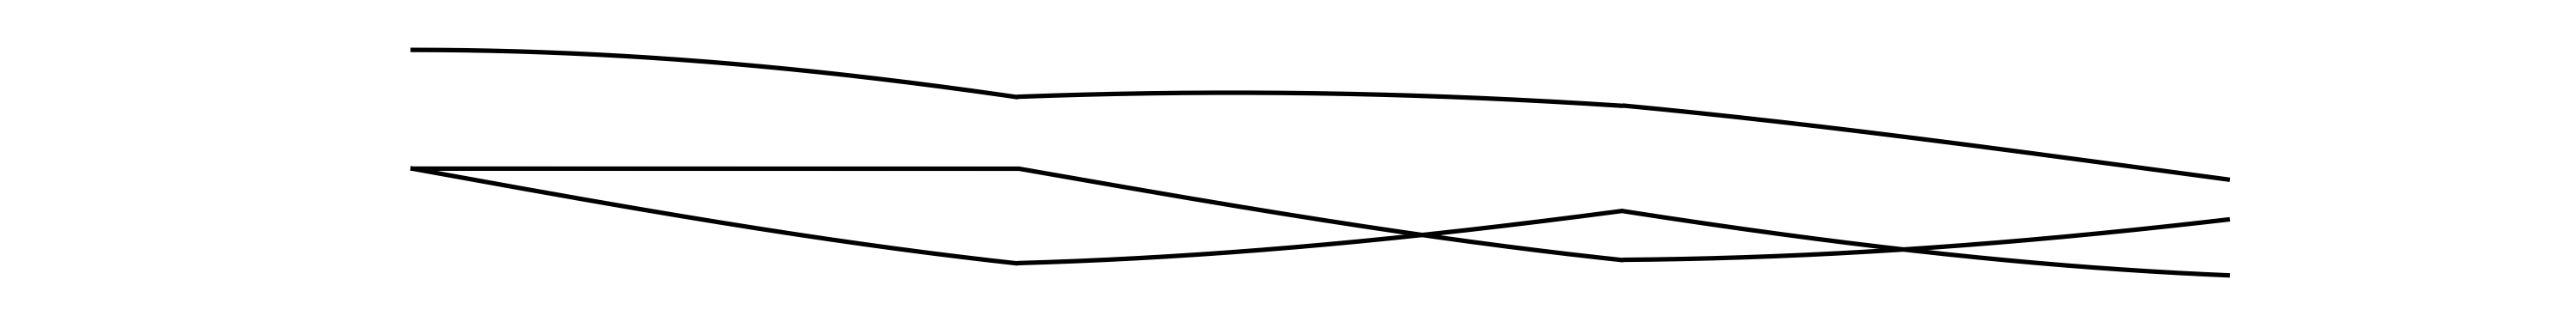

In [107]:
length = Data_arczte.points_per_spoke * 3

# Plot gradients
plt.figure(figsize=(16,2))
plt.plot(Data_arczte.grad_first_seg[0, 0:length], linewidth=2, color='k')
plt.plot(Data_arczte.grad_first_seg[1, 0:length], linewidth=2, color='k')
plt.plot(Data_arczte.grad_first_seg[2, 0:length], linewidth=2, color='k')
# plt.ylim([-0.25,0.7])

# To plot without grid lines
ax = plt.gca()
ax.set_axis_off()

In [108]:
plt.savefig('arc_zte_grads.svg', dpi=500) 

<IPython.core.display.Javascript object>


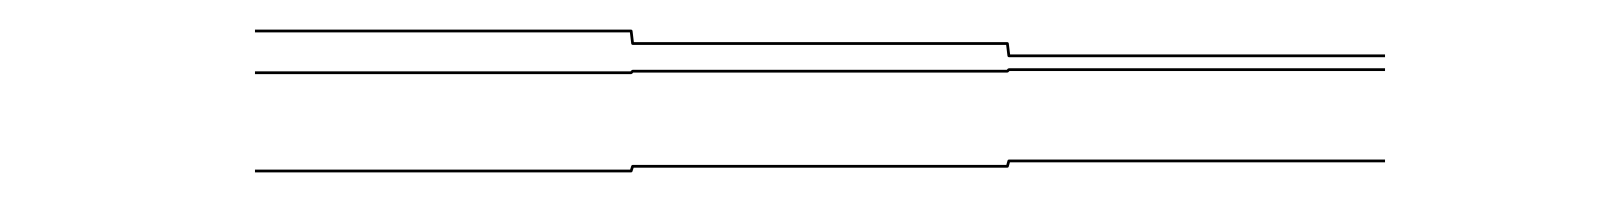

In [103]:
endpoints = Data_phyllozte.coord_radial_spokes[100:104, -1, :]
grads = np.ones((256, 3)) * endpoints[0, :]
grads = np.concatenate((grads, np.ones((256, 3)) * endpoints[1, :]))
grads = np.concatenate((grads, np.ones((256, 3)) * endpoints[2, :]))
grads = grads.T

# Plot gradients
plt.figure(figsize=(16,2))
plt.plot(grads[0, :], linewidth=2, color='k')
plt.plot(grads[1, :], linewidth=2, color='k')
plt.plot(grads[2, :], linewidth=2, color='k')
# plt.ylim([-0.25,0.7])

# To plot without grid lines
ax = plt.gca()
ax.set_axis_off()

In [104]:
plt.savefig('radial_zte_grads.svg', dpi=500) 

## Plot without axes

<IPython.core.display.Javascript object>


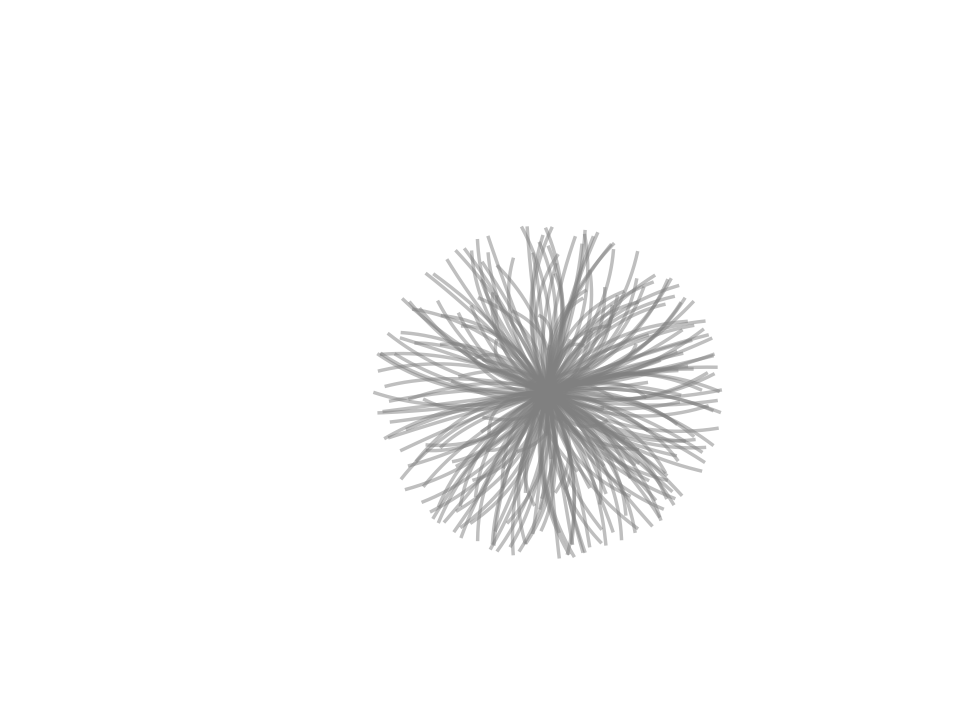

In [45]:
# Plot waspi spokes
plot_3d_axes()
ax = plt.gca()
seg_num = 0
spokes_per_seg = 256
seg = 50
for i in np.arange(seg*256, (seg+1)*256):
    ax.plot(Data_arczte.coord_sampl_hires[i, :, 0], 
            Data_arczte.coord_sampl_hires[i, :, 1], 
            Data_arczte.coord_sampl_hires[i, :, 2], 
            color='grey', alpha=0.5)
ax.elev = 16
ax.azim = 140

# To plot without grid lines
ax.set_axis_off()
fig = plt.gcf()
ax.elev = 58
ax.azim = 144

In [46]:
plt.savefig('saved_figures/arc_spokes_seg50.png', dpi=500)